# Predicting Unemployment Trends

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from dotenv import load_dotenv
import os
from prophet import Prophet
import plotly.express as px

## Import Data

#### US States and Abbrevations - from file

In [2]:
# Import a dictionary of US States and abbrevations
us_states = np.load('Resources/us_states.npy', allow_pickle='TRUE').item()

#### Unemployment data - from Federal Reserve Bank of St. Louis (FRED)

In [3]:
# Create and empty dataframe to hold all the unemployment values
unemployment_df = pd.DataFrame()
# Load environment variables and New York Times API key
load_dotenv()
fred_api_key = os.getenv("FRED") # calling environmental variables
fred_api_key = 'f65100380bee55fc01cf4fd7e4604408'
# Display message informing the user that the download can take a minute
print('This can take a few seconds as the program is downloading data for each state...')

for key in us_states:
    # Create series ID that needs to be downloaded
    series_id = us_states[key] + 'URN'
    # Create the query url
    query_url = 'https://api.stlouisfed.org/fred/series/observations?' +\
                f'series_id={series_id}&api_key={fred_api_key}&' +\
                'file_type=json&observation_start=1980-01-01'
    # Get a reponse and convert it to json
    response = requests.get(query_url).json()
    # Create a temp dataframe to hold the values downloaded
    temp_df = pd.DataFrame(response['observations'])\
        .drop(['realtime_start', 'realtime_end'], axis=1)\
        .set_index('date')\
        .rename(columns={'value': us_states[key]}) 
    # Add the data to the unemployment_df
    # If employment_df is empty then assign the temp_df value to it
    if unemployment_df.empty:
        unemployment_df = temp_df
    # Else join unemployment_df with temp_df
    else:
        unemployment_df = unemployment_df.join(temp_df, how='outer')  

# Change index name to Date
unemployment_df.index.names = ['Date']
# Change index type to datetime
unemployment_df.index = pd.to_datetime(unemployment_df.index)

This can take a few seconds as the program is downloading data for each state...


In [4]:
# Check data type of the index
unemployment_df.index.dtype

dtype('<M8[ns]')

In [5]:
# Convert the data in the columns to float
unemployment_df = unemployment_df.astype('float')

In [6]:
# Display head of unemployment dataframe
unemployment_df.head()

AL    AK   AZ   AR   CA   CO   CT   DE   FL   GA  ...   SD   TN  \
Date                                                           ...             
1980-01-01  8.1   9.6  6.2  7.3  6.8  5.1  5.8  7.8  6.0  5.6  ...  4.7  6.8   
1980-02-01  8.2  10.4  5.5  7.3  6.8  5.0  5.7  7.3  5.3  5.8  ...  4.5  6.7   
1980-03-01  7.6  10.1  5.8  6.6  6.6  5.0  5.2  6.9  5.1  5.7  ...  4.7  6.3   
1980-04-01  7.7  10.8  5.7  6.9  6.6  5.3  5.3  7.3  5.3  5.9  ...  4.6  6.3   
1980-05-01  8.1   9.7  6.6  7.4  6.5  6.0  5.6  6.9  5.6  6.3  ...  4.8  6.7   

             TX   UT   VT   VA   WA    WV   WI   WY  
Date                                                 
1980-01-01  5.2  5.8  6.0  5.2  8.4   9.3  6.0  4.1  
1980-02-01  5.1  6.2  5.9  4.9  8.1   9.6  6.4  4.1  
1980-03-01  5.0  6.1  5.7  4.7  7.4   9.7  6.6  4.2  
1980-04-01  4.8  5.9  6.0  4.7  7.5  10.0  7.1  3.5  
1980-05-01  5.1  5.7  6.0  5.2  7.7   9.8  7.8  3.5  

[5 rows x 50 columns]

In [7]:
# Check unemployment dataframe for any null values
sum(unemployment_df.isnull().sum())

0

#### PCE Inflation rate

In [8]:
series_id ='PCETRIM6M680SFRBDAL'

In [9]:
query_url = 'https://api.stlouisfed.org/fred/series/observations?' +\
                f'series_id={series_id}&api_key={fred_api_key}&' +\
                'file_type=json&observation_start=1980-01-01'

In [10]:
# Get a reponse and convert it to json
response = requests.get(query_url).json()
# Create a temp dataframe to hold the values downloaded
inflation_df = pd.DataFrame(response['observations'])\
                .drop(['realtime_start', 'realtime_end'], axis=1)\
                .set_index('date')\
                .rename(columns={'value': 'Inflation'}) 
# Change index name to Date
inflation_df.index.names = ['Date']
# Check the head of the dataframe
inflation_df.head()

Inflation
Date                
1980-01-01      8.81
1980-02-01       9.0
1980-03-01      9.17
1980-04-01      8.59
1980-05-01      8.81

In [11]:
# Convert index to datetime
inflation_df.index = pd.to_datetime(inflation_df.index)
# Check if data type of the index
inflation_df.index.dtype

dtype('<M8[ns]')

In [12]:
# Change the data to type float
inflation_df = inflation_df.astype('float')

In [13]:
# Check the head of the dataframe
inflation_df.head()

Inflation
Date                 
1980-01-01       8.81
1980-02-01       9.00
1980-03-01       9.17
1980-04-01       8.59
1980-05-01       8.81

In [14]:
# Check for any null values
sum(inflation_df.isnull().sum())

0

In [15]:
# Visualiztion of the PCE Inflation rate
fig = px.line(inflation_df, 
        labels={'value': 'Inflation rate', 'Date': 'Year'}, 
        title='Inflation Rate vs Year')
fig.update_layout(showlegend=False)
fig.show()

#### Fed Funds Rate

In [16]:
series_id = 'FEDFUNDS'
fedfunds_url = 'https://api.stlouisfed.org/fred/series/observations?' +\
                f'series_id={series_id}&api_key={fred_api_key}&' +\
                'file_type=json&observation_start=1980-01-01'
response = requests.get(fedfunds_url).json()

In [17]:
fedfunds_df = pd.DataFrame(response['observations'])\
                        .drop(['realtime_start', 'realtime_end'], axis=1)\
                        .set_index('date')\
                        .rename(columns={'value': 'Fed Funds'}) 
fedfunds_df.index.names=['Date']

fedfunds_df.head()

Fed Funds
Date                
1980-01-01     13.82
1980-02-01     14.13
1980-03-01     17.19
1980-04-01     17.61
1980-05-01     10.98

In [18]:
# Convert index to datetime
fedfunds_df.index = pd.to_datetime(fedfunds_df.index)
# Check if data type of the index
fedfunds_df.index.dtype

dtype('<M8[ns]')

In [19]:
# Change the data to type float
fedfunds_df = fedfunds_df.astype('float')

In [20]:
# Check if there are any null values
sum(fedfunds_df.isnull().sum())

0

In [21]:
# Visualiztion of the Fed Funds Rate
fig = px.line(fedfunds_df, 
        labels={'value': 'Fed Funds rate', 'Date': 'Year'}, 
        title='Fed Funds Rate vs Year')
fig.update_layout(showlegend=False)
fig.data[0].line.color = '#FF0000'
fig.show()

### Get the target states on which the analysis needs to be carried out

#### Filter the data for the states with the highest average unemployment over the last 10 years

In [22]:
years = 10
unemployment_10y_df = unemployment_df.iloc[(years*-12):,:]
unemployment_10y_df

AL   AK   AZ   AR   CA   CO   CT   DE   FL   GA  ...   SD   TN  \
Date                                                          ...             
2014-04-01  6.2  6.8  6.2  5.4  7.3  5.5  6.3  5.4  6.1  6.8  ...  3.4  6.0   
2014-05-01  6.5  6.7  6.7  5.8  7.3  5.0  6.7  5.5  6.4  7.2  ...  3.2  6.3   
2014-06-01  7.2  6.9  7.1  6.0  7.6  5.0  6.7  5.9  6.6  7.6  ...  3.2  7.1   
2014-07-01  7.3  6.4  7.4  6.4  8.0  4.9  7.0  6.0  6.9  7.8  ...  3.1  7.3   
2014-08-01  7.0  6.1  7.3  5.9  7.7  4.6  6.8  5.9  6.8  7.5  ...  3.2  6.9   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-11-01  2.5  4.5  3.8  3.2  4.9  3.2  3.9  3.6  3.0  2.8  ...  1.7  3.1   
2023-12-01  2.7  4.6  3.8  3.4  5.1  3.3  4.0  3.7  2.9  2.9  ...  2.0  3.0   
2024-01-01  3.4  5.2  3.8  3.9  5.7  3.8  5.0  4.2  3.1  3.1  ...  2.2  3.5   
2024-02-01  3.4  5.5  3.6  3.5  5.6  4.2  5.4  4.0  3.1  3.1  ...  2.7  2.8   
2024-03-01  3.0  4.8  2.9  3.3  5.3  3.8  4.2  4.0  3.3  3.2  ...  2.0  3.0   

             TX   UT   VT   VA   WA   WV   WI   WY  
Date                                                
2014-04-01  4.8  3.3  4.1  4.7  5.5  6.3  5.5  4.3  
2014-05-01  5.1  3.4  3.8  5.2  5.8  6.3  5.3  4.3  
2014-06-01  5.5  3.9  4.0  5.2  5.6  6.4  5.6  4.3  
2014-07-01  5.7  3.8  4.1  5.3  5.8  6.6  5.4  4.2  
2014-08-01  5.4  3.9  4.0  5.4  5.8  6.6  5.1  4.1  
...         ...  ...  ...  ...  ...  ...  ...  ...  
2023-11-01  3.5  2.5  2.0  2.9  4.3  3.7  2.7  2.7  
2023-12-01  3.5  2.5  2.2  2.7  4.6  3.9  2.9  2.6  
2024-01-01  4.1  3.0  2.7  2.7  5.4  4.8  2.8  3.7  
2024-02-01  4.4  3.3  2.6  2.9  5.6  5.0  3.3  3.6  
2024-03-01  4.1  2.8  2.1  2.4  5.1  4.9  3.5  3.3  

[120 rows x 50 columns]

In [23]:
# Geographically where are the unemployment is the highest and lowest over the past 10 years
fig = px.choropleth(unemployment_10y_df, 
                    locations=unemployment_10y_df.columns.tolist(), 
                    locationmode="USA-states", 
                    scope="usa", 
                    color=unemployment_10y_df.mean().tolist(), 
                    color_continuous_scale='reds', 
                    title='Unemployment in the US',
                    labels={'color':'Rate'})
fig.show()

In [24]:
# Get the mean of each column, sort the values and get the bottom five values
highest_unemployment = unemployment_10y_df\
                            .mean()\
                            .sort_values()\
                            .tail()
highest_unemployment

IL    5.596667
NM    5.789167
CA    5.838333
AK    6.035833
NV    6.425833
dtype: float64

In [25]:
# Plot the states with the highest unemployment
fig = px.bar(highest_unemployment, 
             labels={'value': 'Unemployment Rate', 'index': 'State', 'color': 'Rate'},
             color=highest_unemployment,
             color_continuous_scale = 'pinkyl'
            )
fig.update_layout(showlegend=False, yaxis_range=[5,6.5])
fig.show()

In [26]:
# Get the mean of each column, sort the values and get the bottom five values
highest_unemployment = highest_unemployment\
                            .index\
                            .tolist()
# View the list
highest_unemployment

['IL', 'NM', 'CA', 'AK', 'NV']

#### Filter the data for the states with the lowest average unemployment over the last 10 years

In [27]:
# Get the mean of each column, sort the values, get the bottom five values, get the index and convert it to a list
lowest_unemployment = unemployment_10y_df\
                            .mean()\
                            .sort_values()\
                            .head()\
# View the dataseries
lowest_unemployment

ND    2.737500
SD    2.839167
NE    2.927500
VT    3.125833
UT    3.150000
dtype: float64

In [28]:
# Plot the states with the lowest employment
fig = px.bar(lowest_unemployment, 
             labels={'value': 'Unemployment Rate', 'index': 'State', 'color': 'Rate'},
             color=lowest_unemployment,
             color_continuous_scale = 'algae'
            )
fig.update_layout(showlegend=False, yaxis_range=[2.5,3.5])
fig.show()

In [29]:
lowest_unemployment = lowest_unemployment\
                            .index\
                            .tolist()
lowest_unemployment

['ND', 'SD', 'NE', 'VT', 'UT']

### Explore Relationships and Visualizations

#### Unemployment and PCE Inflation Rate

In [30]:
# Correlation for the states with the highest unemployment
corr_unemp_inflation = []
for state in highest_unemployment:
    state_df = unemployment_df.loc[:,state]
    corr_unemp_inflation.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
    
corr_high_unemp_inflation_df = pd.DataFrame(
    {'State': highest_unemployment,
     'Correlation': corr_unemp_inflation
    })
corr_high_unemp_inflation_df

State  Correlation
0    IL     0.169862
1    NM     0.182617
2    CA    -0.142199
3    AK     0.317510
4    NV    -0.111754

In [31]:
# Correlation for the states with the lowest unemployment
corr_unemp_inflation = []
for state in lowest_unemployment:
    state_df = unemployment_df.loc[:,state]
    corr_unemp_inflation.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
    
corr_low_unemp_inflation_df = pd.DataFrame(
    {'State': lowest_unemployment,
     'Correlation': corr_unemp_inflation
    })
corr_low_unemp_inflation_df

State  Correlation
0    ND     0.396038
1    SD     0.296343
2    NE     0.140649
3    VT     0.198921
4    UT     0.270922

In [32]:
# Create a list of lagged periods
lagged_period = [6, 12, 18, 24]

In [33]:
# Create a list of lagged dataframes using the lagged periods
lagged_unemployment_dfs = [unemployment_df.shift(period).dropna() for period in lagged_period]
# View the first lagged unemployment dataframe in the list
lagged_unemployment_dfs[0]

AL    AK   AZ   AR   CA   CO   CT   DE   FL   GA  ...   SD   TN  \
Date                                                           ...             
1980-07-01  8.1   9.6  6.2  7.3  6.8  5.1  5.8  7.8  6.0  5.6  ...  4.7  6.8   
1980-08-01  8.2  10.4  5.5  7.3  6.8  5.0  5.7  7.3  5.3  5.8  ...  4.5  6.7   
1980-09-01  7.6  10.1  5.8  6.6  6.6  5.0  5.2  6.9  5.1  5.7  ...  4.7  6.3   
1980-10-01  7.7  10.8  5.7  6.9  6.6  5.3  5.3  7.3  5.3  5.9  ...  4.6  6.3   
1980-11-01  8.1   9.7  6.6  7.4  6.5  6.0  5.6  6.9  5.6  6.3  ...  4.8  6.7   
...         ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-11-01  2.1   4.0  3.8  2.9  4.3  3.0  3.4  3.7  2.7  3.3  ...  2.0  3.1   
2023-12-01  2.8   4.4  4.2  3.5  4.7  3.5  3.7  4.2  3.1  3.5  ...  2.1  3.7   
2024-01-01  2.6   3.8  4.3  3.7  4.8  3.3  3.8  4.1  3.1  3.2  ...  1.7  3.5   
2024-02-01  2.8   3.8  4.5  3.6  5.2  3.4  3.9  4.4  3.3  3.6  ...  2.1  3.4   
2024-03-01  2.6   4.0  4.2  3.5  4.9  3.1  3.7  3.9  3.1  3.1  ...  1.8  3.3   

             TX   UT   VT   VA   WA    WV   WI   WY  
Date                                                 
1980-07-01  5.2  5.8  6.0  5.2  8.4   9.3  6.0  4.1  
1980-08-01  5.1  6.2  5.9  4.9  8.1   9.6  6.4  4.1  
1980-09-01  5.0  6.1  5.7  4.7  7.4   9.7  6.6  4.2  
1980-10-01  4.8  5.9  6.0  4.7  7.5  10.0  7.1  3.5  
1980-11-01  5.1  5.7  6.0  5.2  7.7   9.8  7.8  3.5  
...         ...  ...  ...  ...  ...   ...  ...  ...  
2023-11-01  3.9  2.6  1.6  2.8  3.6   3.6  2.8  2.7  
2023-12-01  4.2  2.8  2.0  2.9  3.7   4.1  3.5  2.8  
2024-01-01  4.2  2.7  1.8  2.9  3.8   4.0  3.2  2.5  
2024-02-01  4.2  2.9  2.0  3.2  4.3   4.4  3.4  2.5  
2024-03-01  3.9  2.5  2.0  3.0  4.0   3.7  2.9  2.3  

[525 rows x 50 columns]

In [34]:
# Lagged trend for the states with the highest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in highest_unemployment:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
    
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_high_unemp_inflation_df[column_name] = pd.DataFrame(lagged_corr)
    # Increase count by 1
    count += 1
# Display the dataframe
corr_high_unemp_inflation_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    IL     0.169862         0.142479          0.170357          0.256839   
1    NM     0.182617         0.217136          0.318316          0.443257   
2    CA    -0.142199        -0.166045         -0.125186         -0.041590   
3    AK     0.317510         0.319977          0.387615          0.472766   
4    NV    -0.111754        -0.132773         -0.093309          0.013388   

   Lagged 24 Months  
0          0.301196  
1          0.523164  
2         -0.008506  
3          0.540515  
4          0.070652

In [35]:
# Lagged trend for the states with the lowest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in lowest_unemployment:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
    
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_low_unemp_inflation_df[column_name] = pd.DataFrame(lagged_corr)
    # Increase count by 1
    count += 1
# Display the dataframe
corr_low_unemp_inflation_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    ND     0.396038         0.385978          0.450929          0.540048   
1    SD     0.296343         0.267433          0.293300          0.367315   
2    NE     0.140649         0.113049          0.152373          0.250585   
3    VT     0.198921         0.154671          0.164106          0.202576   
4    UT     0.270922         0.241181          0.264121          0.330126   

   Lagged 24 Months  
0          0.590893  
1          0.422722  
2          0.358985  
3          0.210711  
4          0.386400

#### Unemployment and Fed Funds Rate

In [36]:
# Correlation for the states with the highest unemployment
corr_unemp_fedfunds = []
for state in highest_unemployment:
    state_df = unemployment_df.loc[:,state]
    corr_unemp_fedfunds.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
# Create a dataframe      
corr_high_unemp_fedfunds_df = pd.DataFrame(
    {'State': highest_unemployment,
     'Correlation': corr_unemp_fedfunds
    })
# Check the dataframe
corr_high_unemp_fedfunds_df

State  Correlation
0    IL     0.141123
1    NM     0.278848
2    CA    -0.144722
3    AK     0.431423
4    NV    -0.200720

In [37]:
# Correlation for the states with the lowest unemployment
corr_unemp_fedfunds = []
for state in lowest_unemployment:
    state_df = unemployment_df.loc[:,state]
    corr_unemp_fedfunds.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
# Create a dataframe    
corr_low_unemp_fedfunds_df = pd.DataFrame(
    {'State': lowest_unemployment,
     'Correlation': corr_unemp_fedfunds
    })
# Check the dataframe
corr_low_unemp_fedfunds_df

State  Correlation
0    ND     0.496182
1    SD     0.344919
2    NE     0.174563
3    VT     0.221536
4    UT     0.321065

In [38]:
# Lagged trend for the states with the highest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in highest_unemployment:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
    
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_high_unemp_fedfunds_df[column_name] = pd.DataFrame(lagged_corr)
    # Increase count by 1
    count += 1
# Display the dataframe
corr_high_unemp_fedfunds_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    IL     0.141123         0.125918          0.126238          0.154807   
1    NM     0.278848         0.295246          0.350752          0.433590   
2    CA    -0.144722        -0.167435         -0.159875         -0.118262   
3    AK     0.431423         0.432879          0.439727          0.504798   
4    NV    -0.200720        -0.217424         -0.220424         -0.203312   

   Lagged 24 Months  
0          0.196729  
1          0.531266  
2         -0.052784  
3          0.561975  
4         -0.163897

In [39]:
# Lagged trend for the states with the lowest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in lowest_unemployment:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
    
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_low_unemp_fedfunds_df[column_name] = pd.DataFrame(lagged_corr)
    # Increase count by 1
    count += 1
# Display the dataframe
corr_low_unemp_fedfunds_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    ND     0.496182         0.497873          0.499332          0.537934   
1    SD     0.344919         0.347072          0.342120          0.370169   
2    NE     0.174563         0.163145          0.159541          0.189788   
3    VT     0.221536         0.193898          0.173511          0.186581   
4    UT     0.321065         0.313290          0.317538          0.339595   

   Lagged 24 Months  
0          0.566258  
1          0.378367  
2          0.219910  
3          0.214599  
4          0.365842

#### Forecast unemployment rate for states

In [40]:
# Create a function that can be used for every state
def predict(df, duration):
    df.reset_index(inplace=True)
    df.columns = ['ds', 'y']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=duration, freq='M')
    forecast = m.predict(future)
    return m,forecast

10:28:20 - cmdstanpy - INFO - Chain [1] start processing
10:28:20 - cmdstanpy - INFO - Chain [1] done processing
10:28:20 - cmdstanpy - INFO - Chain [1] start processing
10:28:20 - cmdstanpy - INFO - Chain [1] done processing
10:28:20 - cmdstanpy - INFO - Chain [1] start processing
10:28:20 - cmdstanpy - INFO - Chain [1] done processing
10:28:20 - cmdstanpy - INFO - Chain [1] start processing
10:28:20 - cmdstanpy - INFO - Chain [1] done processing
10:28:21 - cmdstanpy - INFO - Chain [1] start processing
10:28:21 - cmdstanpy - INFO - Chain [1] done processing


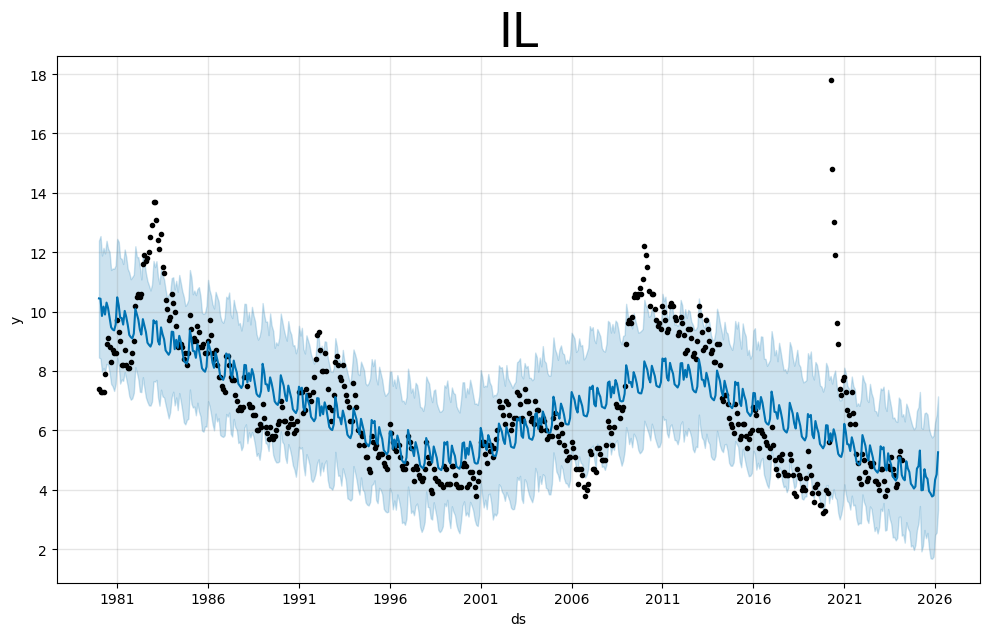

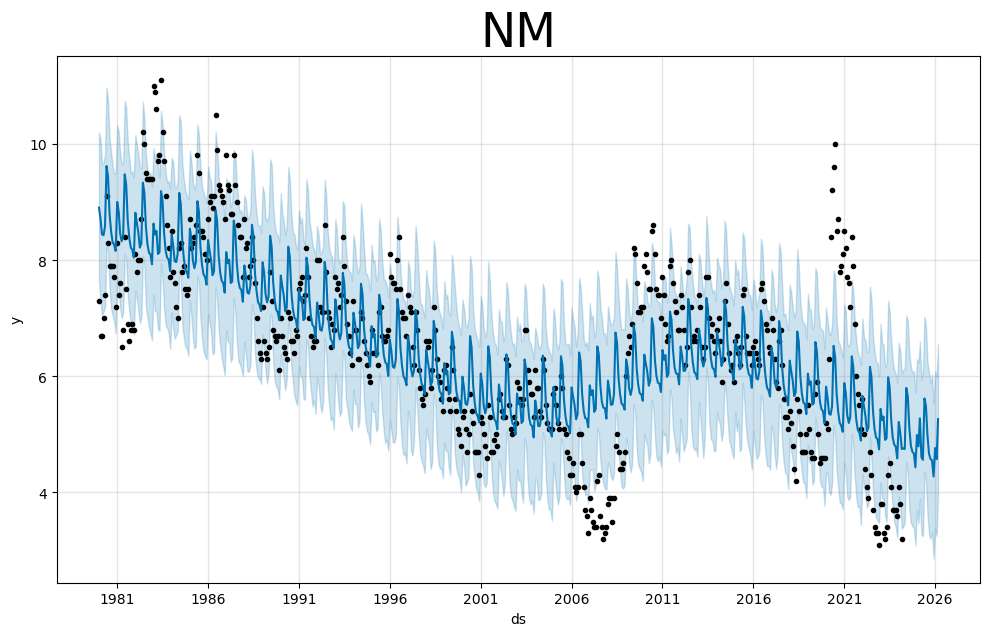

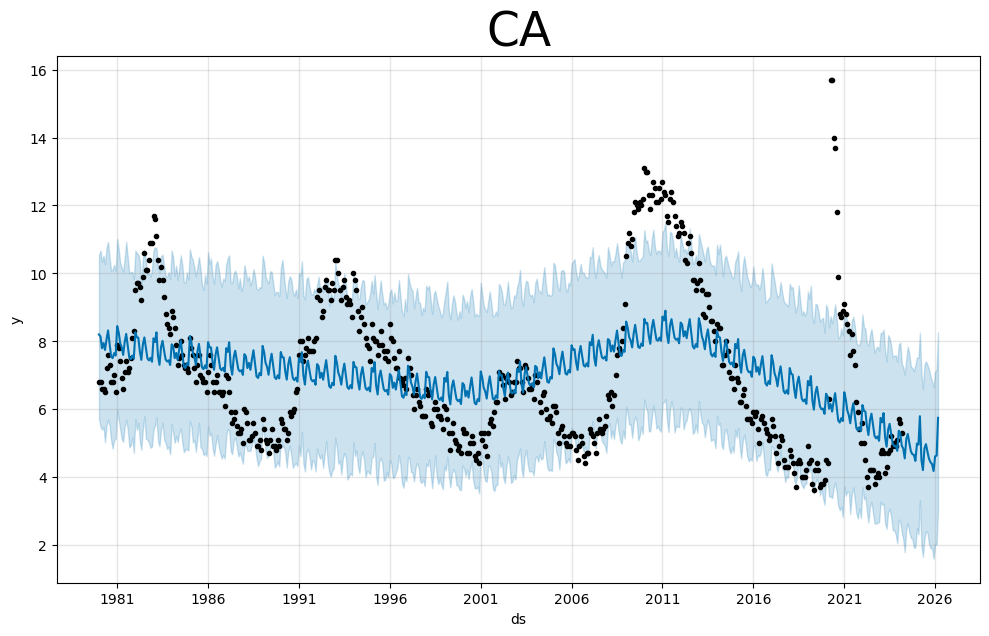

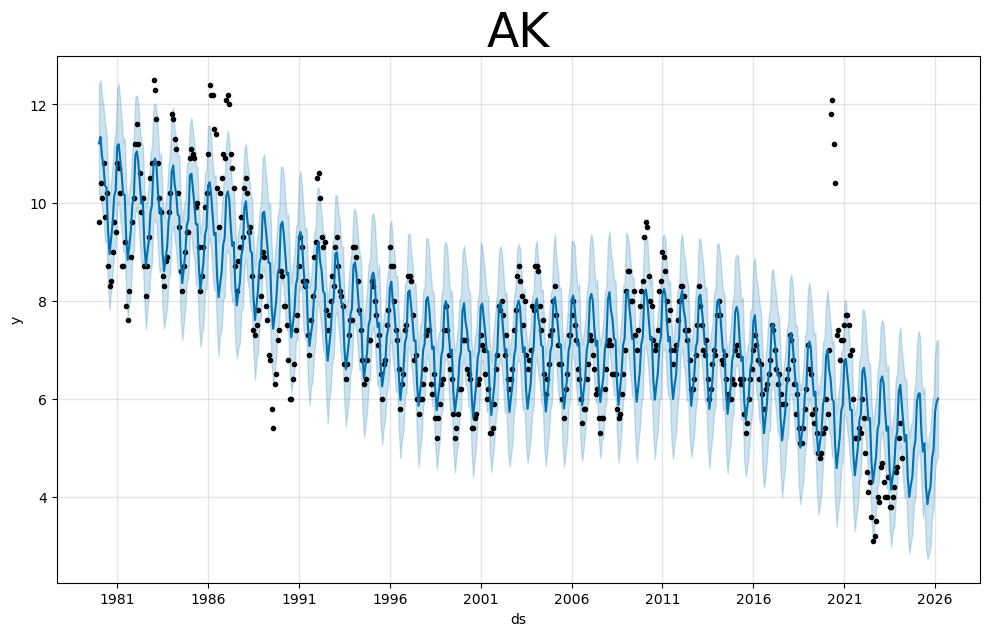

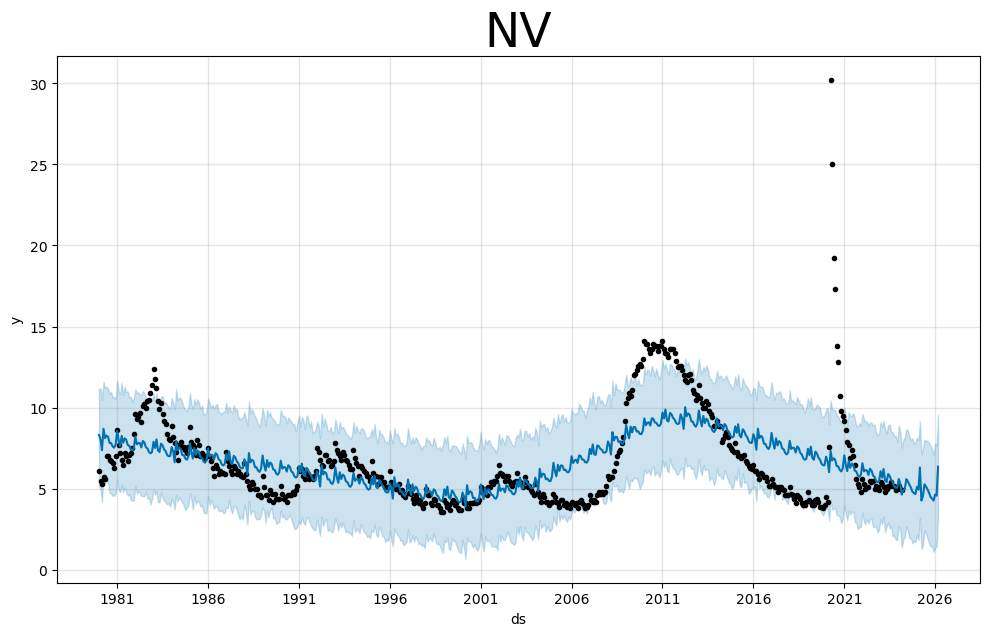

In [42]:
# Forecast unemployment for the states with the highest unemployment
period = 24 # months
# Loop through the states
for state in highest_unemployment:
    m,forecast = predict(pd.DataFrame(unemployment_df.loc[:,state]), period)
    fig = m.plot(forecast)
    ax = fig.gca()
    ax.set_title(state, size=34)

10:28:23 - cmdstanpy - INFO - Chain [1] start processing
10:28:23 - cmdstanpy - INFO - Chain [1] done processing
10:28:23 - cmdstanpy - INFO - Chain [1] start processing
10:28:23 - cmdstanpy - INFO - Chain [1] done processing
10:28:23 - cmdstanpy - INFO - Chain [1] start processing
10:28:23 - cmdstanpy - INFO - Chain [1] done processing
10:28:23 - cmdstanpy - INFO - Chain [1] start processing
10:28:23 - cmdstanpy - INFO - Chain [1] done processing
10:28:23 - cmdstanpy - INFO - Chain [1] start processing
10:28:23 - cmdstanpy - INFO - Chain [1] done processing


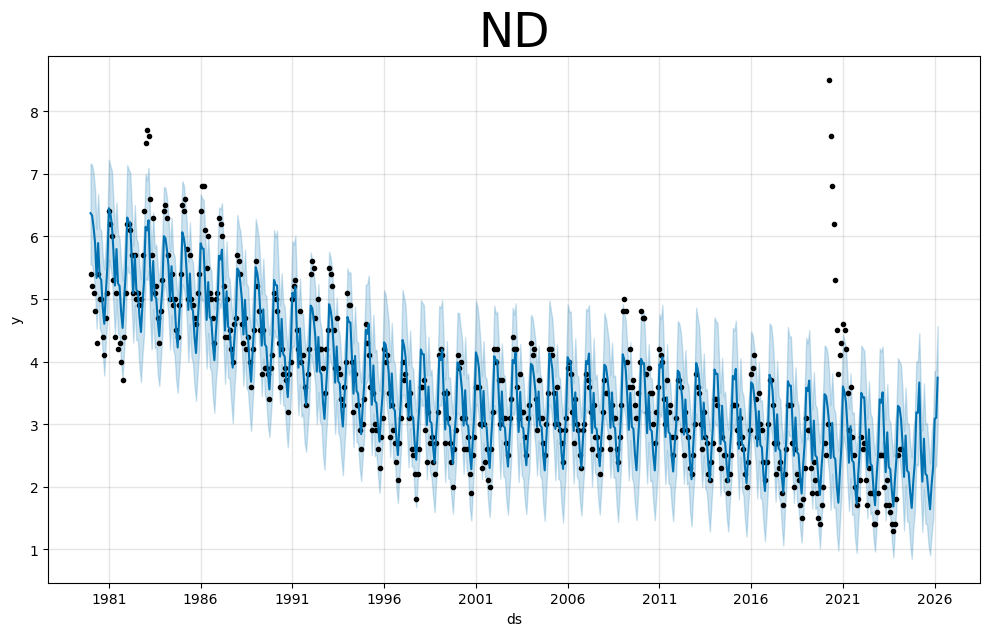

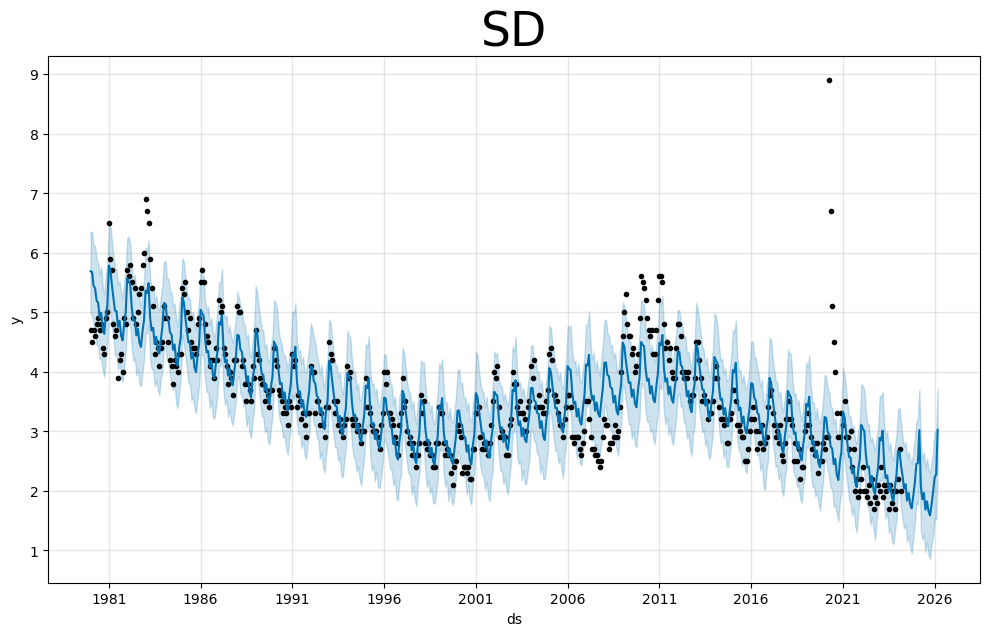

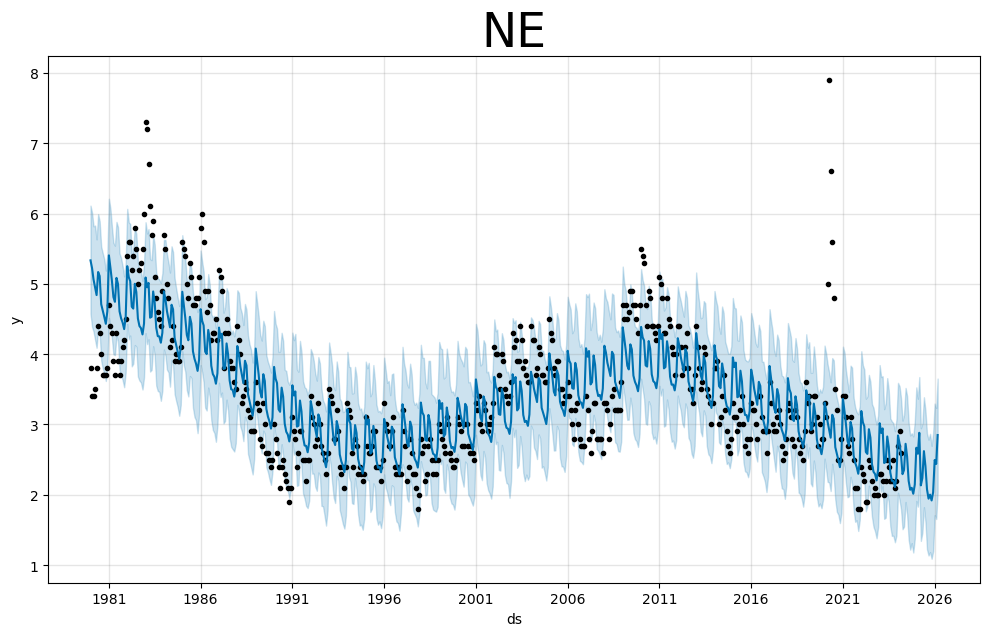

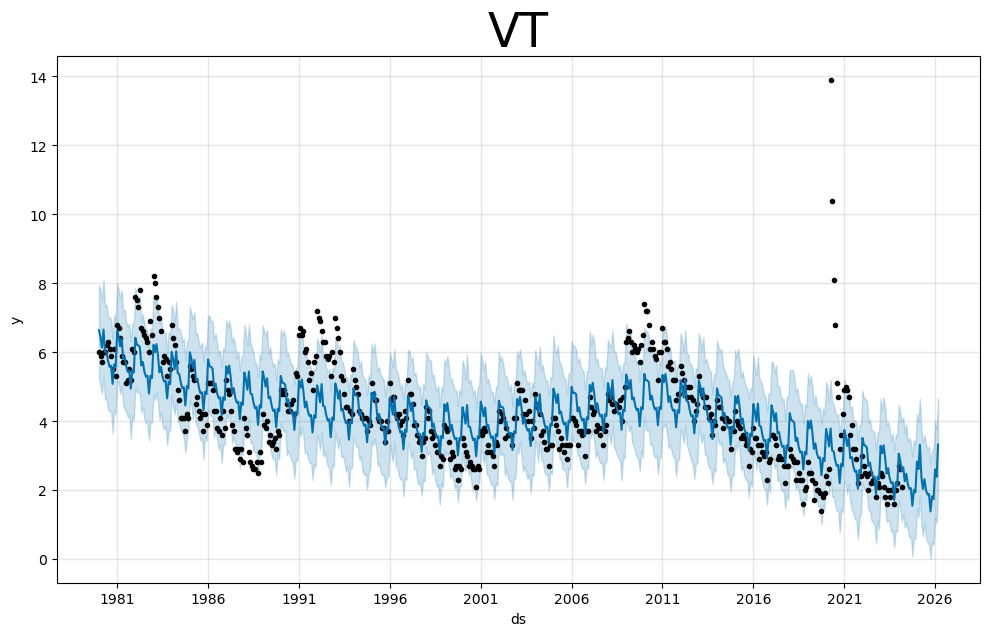

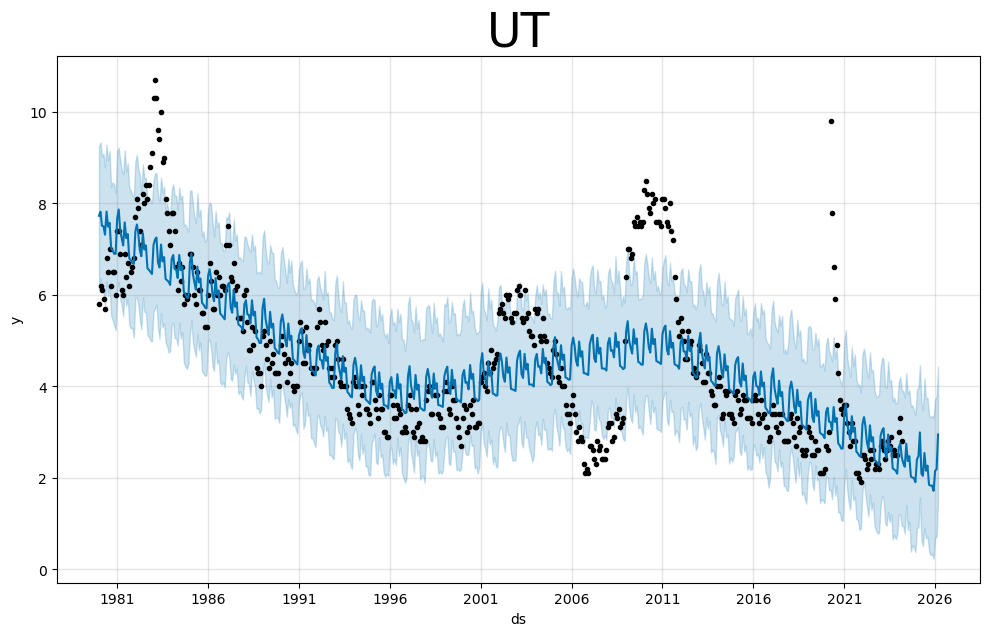

In [43]:
# Forecast unemployment for the states with the lowest unemployment
period = 24 # months
# Loop through the states
for state in lowest_unemployment:
    m,forecast = predict(pd.DataFrame(unemployment_df.loc[:,state]), period)
    fig = m.plot(forecast)
    ax = fig.gca()
    ax.set_title(state, size=34)

### Conclusion and Recommendations

#### 1. Unemployment and PCE Inflation rate have a low-moderate correlation depending on the state. There is a stronger correlation between lagged unemployment and PCE inflation. This would imply unemployment will continue to fall if PCE inflation rate continues to drop

#### 2. Unemployment and Fed funds rate have a low-moderate correlation depending on the state. There is a stronger correlation between the lagged unemployment and Fed Funds rate. This would imply unemployment will continue to fall if the Fed starts to reduce the Fed Funds rate

#### 3. The Prophet forecast model shows a downward trend in unemployment rates.

#### All three trends forecast a drop in unemployment, on the assumption that the Federal reserve will cut the Fed Funds rate as inflation keeps moving towards their target range